In [24]:
# 2022-1-2
from scipy.interpolate import griddata
from PIL import Image
import SimpleITK as sitk
import matplotlib.pyplot  as plt
import matplotlib.image as img
import numpy as np

def reslice (Ori_Image,x = [1,0,0],y = [0,1,0],z = [0,0,1]):
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    z = z/np.linalg.norm(z)
    size_of_image = Ori_Image.shape

    # Three Matrix to store transfered indexs of coordinate
    Coor_Matrix = np.zeros([3,size_of_image[0],size_of_image[1],size_of_image[2]])

    norm_X = np.linalg.norm(x)
    norm_Y = np.linalg.norm(y)
    norm_Z = np.linalg.norm(z)
    print('finish one ')
                
    # faster method to calculate reslice coordinate

    # caiculate a row then expend to one plane
    for i in range (2):
        for k in range(size_of_image[2]):

            Coor_Matrix[0,i,0,k] = np.dot([i,0,k],x)/norm_X
            Coor_Matrix[1,i,0,k] = np.dot([i,0,k],y)/norm_Y
            Coor_Matrix[2,i,0,k] = np.dot([i,0,k],z)/norm_Z

            Coor_Matrix[0,i,1,k] = np.dot([i,1,k],x)/norm_X
            Coor_Matrix[1,i,1,k] = np.dot([i,1,k],y)/norm_Y
            Coor_Matrix[2,i,1,k] = np.dot([i,1,k],z)/norm_Z

        G_X = Coor_Matrix[0,i,1,:] - Coor_Matrix[0,i,0,:]
        G_Y = Coor_Matrix[1,i,1,:] - Coor_Matrix[1,i,0,:]
        G_Z = Coor_Matrix[2,i,1,:] - Coor_Matrix[2,i,0,:]

        for j in range(2,size_of_image[1]):
            Coor_Matrix[0,i,j,:] = Coor_Matrix[0,i,0,:] + G_X * j
            Coor_Matrix[1,i,j,:] = Coor_Matrix[1,i,0,:] + G_Y * j
            Coor_Matrix[2,i,j,:] = Coor_Matrix[2,i,0,:] + G_Z * j
    
    # calculate a plane then expand to a volume
    G_X = Coor_Matrix[0,1,:,:] - Coor_Matrix[0,0,:,:]
    G_Y = Coor_Matrix[1,1,:,:] - Coor_Matrix[1,0,:,:]
    G_Z = Coor_Matrix[2,1,:,:] - Coor_Matrix[2,0,:,:]
    
    for i in range (2,size_of_image[0]):
        Coor_Matrix[0,i,:,:] = Coor_Matrix[0,0,:,:] + G_X * i
        Coor_Matrix[1,i,:,:] = Coor_Matrix[1,0,:,:] + G_Y * i
        Coor_Matrix[2,i,:,:] = Coor_Matrix[2,0,:,:] + G_Z * i


    print('finish two ')
    # create output image
    range_of_coor = np.zeros([3,2])
    Coor_Matrix = np.round(Coor_Matrix)
    range_of_coor[0,0] = np.max(Coor_Matrix[0,:,:,:]);range_of_coor[0,1] = np.min(Coor_Matrix[0,:,:,:])
    range_of_coor[1,0] = np.max(Coor_Matrix[1,:,:,:]);range_of_coor[1,1] = np.min(Coor_Matrix[1,:,:,:])
    range_of_coor[2,0] = np.max(Coor_Matrix[2,:,:,:]);range_of_coor[2,1] = np.min(Coor_Matrix[2,:,:,:])
    Range_Cor = []
    Range_Cor.append(np.int16(range_of_coor[0,0] - range_of_coor[0,1]))
    Range_Cor.append(np.int16(range_of_coor[1,0] - range_of_coor[1,1]))
    Range_Cor.append(np.int16(range_of_coor[2,0] - range_of_coor[2,1]))
    Range_Cor = np.array(Range_Cor)

    Coor_Matrix[0,:,:,:] = Coor_Matrix[0,:,:,:] - range_of_coor[0,1]
    Coor_Matrix[1,:,:,:] = Coor_Matrix[1,:,:,:] - range_of_coor[1,1]
    Coor_Matrix[2,:,:,:] = Coor_Matrix[2,:,:,:] - range_of_coor[2,1]

    # calculate output

    C_X = np.reshape(Coor_Matrix[0,:,:,:],-1)
    C_Y = np.reshape(Coor_Matrix[1,:,:,:],-1)
    C_Z = np.reshape(Coor_Matrix[2,:,:,:],-1)
    Value = np.reshape(Ori_Image,-1)
    

    output = np.zeros([Range_Cor[0]+1,Range_Cor[1]+1,Range_Cor[2]+1])
    Out_Image = output.copy()
    Order = (np.where(np.min(Range_Cor) == Range_Cor))[0]


    print('Range = ' + str(Range_Cor))

    if Order[0] == 0:

        Fir_axis = np.linspace(0,Range_Cor[1],Range_Cor[1]+1)
        Sec_axis = np.linspace(0,Range_Cor[2],Range_Cor[2]+1)
        mesh_F, mesh_S  = np.meshgrid(Fir_axis,Sec_axis,indexing='ij')
        Jug_matrix = C_X.copy()
        Fir_mat = C_Y.copy()
        Sec_mat = C_Z.copy()

    elif Order[0] == 1:

        Fir_axis = np.linspace(0,Range_Cor[0],Range_Cor[0]+1)
        Sec_axis = np.linspace(0,Range_Cor[2],Range_Cor[2]+1)
        mesh_F, mesh_S  = np.meshgrid(Fir_axis,Sec_axis,indexing='ij')
        Jug_matrix = C_Y.copy()
        Fir_mat = C_X.copy()
        Sec_mat = C_Z.copy()

    elif Order[0] == 2:

        Fir_axis = np.linspace(0,Range_Cor[0],Range_Cor[0]+1)
        Sec_axis = np.linspace(0,Range_Cor[1],Range_Cor[1]+1)
        mesh_F, mesh_S  = np.meshgrid(Fir_axis,Sec_axis,indexing='ij')
        Jug_matrix = C_Z.copy()
        Fir_mat = C_X.copy()
        Sec_mat = C_Y.copy()

    for i in range(Range_Cor[Order[0]]):
        Index = np.array(np.where(Jug_matrix == i))
        F = Fir_mat[Index] # first
        S = Sec_mat[Index] # second
        point = np.transpose(np.squeeze(np.array([F,S])))
        V = np.transpose(Value[Index])
        if len(point):
            Max = np.max(point,axis=0)
            Min = np.min(point,axis=0)

            if Order[0] == 0:

                if (np.max(Max[0]) != np.min(Min[0])):
                    interp = griddata(point, V ,(mesh_F,mesh_S) ,method='linear')
                    output[i,:,:] = np.squeeze(np.array(interp))
                else:
                    output[i,:,:] = nan

            elif Order[0] == 1:
                if (np.max(Max[0]) != np.min(Min[0])) and (np.max(Max[1]) != np.min(Min[1])) :
                    interp = griddata(point, V ,(mesh_F,mesh_S) ,method='linear')
                    output[:,i,:] = np.squeeze(np.array(interp))
                else:
                    output[:,i,:] = nan

            elif Order[0] == 2:
                if (np.max(Max[0]) != np.min(Min[0])):
                    interp = griddata(point, V ,(mesh_F,mesh_S) ,method='linear')
                    output[:,:,i] = np.squeeze(np.array(interp))
                else:
                    output[:,:,i] = nan
        print(i)

    if Order[0] == 0:
        for I in range(1,Range_Cor[0]):
            Out_Image[I,:,:] = output[I-1,:,:]/6 + output[I,:,:]/6 + output[I+1,:,:] * 4 /6    
    elif Order[0] == 1:
        for I in range(1,Range_Cor[1]):
            Out_Image[:,I,:] = output[:,I-1,:]/6 + output[:,I+1,:]/6 + output[:,I,:] * 4 /6    
    elif Order[0] == 2:
        for I in range(1,Range_Cor[2]):
            Out_Image[:,:,I] = output[:,:,I-1]/6 + output[:,:,I+1]/6 + output[:,:,I] * 4 /6    
            
    return output 
def nonlinear_filter(Image,iteration = 5, K = 30, L = 0.2):


    # Image : input Image
    # iteration: Times of Iteration
    
    # Ori_Img = image

    # halt
    sz = Image.shape
    DIM = len(sz)
    if DIM == 2:
#         print(" DIM = 2 \n size = " + str(sz))
        # --------------------------------------------------------------
        O_Image = np.zeros([sz[0]+2,sz[1]+2])

        for t in range(iteration):
            N_Image = O_Image.copy()
            S_Image = O_Image.copy()
            E_Image = O_Image.copy()
            W_Image = O_Image.copy()

            O_Image[1:sz[0]+1,1:sz[1]+1] = Image
            N_Image[1:sz[0]+1,2:sz[1]+2] = Image
            S_Image[1:sz[0]+1,0:sz[1]  ] = Image
            E_Image[2:sz[0]+2,1:sz[1]+1] = Image
            W_Image[0:sz[0]  ,1:sz[1]+1] = Image

            N_Image = N_Image - O_Image; C_N_Image = np.exp(-N_Image*N_Image/K/K)
            S_Image = O_Image - S_Image; C_S_Image = np.exp(-S_Image*S_Image/K/K)
            E_Image = E_Image - O_Image; C_E_Image = np.exp(-E_Image*E_Image/K/K)
            W_Image = O_Image - W_Image; C_W_Image = np.exp(-W_Image*W_Image/K/K)
            
            # print(A)
            # print("hhhh")
            O_Image = O_Image + L*(N_Image*C_N_Image + S_Image*C_S_Image + E_Image*C_E_Image+ W_Image*C_W_Image )

        return O_Image[1:sz[0]+1,1:sz[1]+1]

    elif DIM == 3:
        
        O_Image = np.zeros([sz[0]+2,sz[1]+2,sz[2]+2])
        for t in range(iteration):

            N_Image = O_Image.copy()
            S_Image = O_Image.copy()
            E_Image = O_Image.copy()
            W_Image = O_Image.copy()
            I_Image = O_Image.copy()
            B_Image = O_Image.copy()

            O_Image[1:sz[0]+1,1:sz[1]+1,1:sz[2]+1] = Image
            N_Image[1:sz[0]+1,2:sz[1]+2,1:sz[2]+1] = Image
            S_Image[1:sz[0]+1,0:sz[1]  ,1:sz[2]+1] = Image
            E_Image[2:sz[0]+2,1:sz[1]+1,1:sz[2]+1] = Image
            W_Image[0:sz[0]  ,1:sz[1]+1,1:sz[2]+1] = Image
            I_Image[1:sz[0]+1,1:sz[1]+1,2:sz[2]+2] = Image
            B_Image[1:sz[0]+1,1:sz[1]+1,0:sz[2]  ] = Image

            N_Image = N_Image - O_Image; C_N_Image = np.exp(-N_Image*N_Image/K/K)
            S_Image = O_Image - S_Image; C_S_Image = np.exp(-S_Image*S_Image/K/K)
            E_Image = E_Image - O_Image; C_E_Image = np.exp(-E_Image*E_Image/K/K)
            W_Image = O_Image - W_Image; C_W_Image = np.exp(-W_Image*W_Image/K/K)
            I_Image = I_Image - O_Image; C_I_Image = np.exp(-I_Image*I_Image/K/K)
            B_Image = O_Image - B_Image; C_B_Image = np.exp(-B_Image*B_Image/K/K)

            O_Image = O_Image + L*(N_Image*C_N_Image + S_Image*C_S_Image + E_Image*C_E_Image+ W_Image*C_W_Image + I_Image*C_I_Image + B_Image*C_B_Image)

        return O_Image[1:sz[0]+1,1:sz[1]+1,1:sz[2]+1]

    else:
        print('Wrong dimension of image')
        return



In [25]:
# Image_Path
Path_of_image = './0001_image.nii'
Path_of_label = './0001_mask.nii'

# Read Image Data
data = sitk.ReadImage(Path_of_image )
array_of_data = sitk.GetArrayFromImage(data)

In [27]:
# ------------------- 3D-filtering before re-slicing ------------------------------

# ------------------------------------------------
# 3d_linear filter 
Filtered_slice = nonlinear_filter(array_of_data)
# Do a 3d slice
Result1 = reslice(Filtered_slice,[1,0.5,0],[0,1,0.5],[0.5,0,1])


finish one 
finish two 
Range = [299 228 285]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


In [33]:
#  reslice
Resliced_slice = reslice(array_of_data,[1,0.5,0],[0,1,0.5],[0.5,0,1])
# 2d Linear filter
sz = Resliced_slice.shape
Result2 = np.zeros(sz)
for i in range (sz[0]):
    Result2[i,:,:] = nonlinear_filter(Resliced_slice[i,:,:])

finish one 
finish two 
Range = [299 228 285]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 

 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 size = (229, 286)
 DIM = 2 
 siz

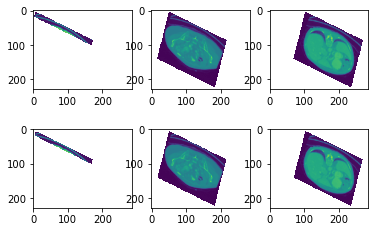

In [34]:
plt.subplot(2, 3, 1)
plt.imshow(Result1[10,:,:])
plt.subplot(2, 3, 2)
plt.imshow(Result1[100,:,:])
plt.subplot(2, 3, 3)
plt.imshow(Result1[200,:,:])

plt.subplot(2, 3, 4)
plt.imshow(Result2[10,:,:])
plt.subplot(2, 3, 5)
plt.imshow(Result2[100,:,:])
plt.subplot(2, 3, 6)
plt.imshow(Result2[200,:,:])

plt.show()

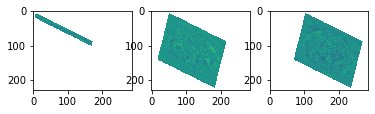

In [36]:
A = Result1-Result2

plt.subplot(2, 3, 1)
plt.imshow(A[10,:,:])
plt.subplot(2, 3, 2)
plt.imshow(A[100,:,:])
plt.subplot(2, 3, 3)
plt.imshow(A[200,:,:])
plt.show()
